# Demo: Teach an LLM to Count using Group Relative Policy Optimization (GRPO)

Let's teach an LLM to count

## What you'll do in this notebook

1.  **Setup**: Import libraries and configure the environment.
2.  **Load the tokenizer and base model**: Use a small, instruction-tuned model as our starting point.
3.  **Create the dataset**: Generate a simple dataset of words and their correct spellings.
4.  **Evaluate the base model**: Test the model's spelling ability *before* fine-tuning to establish a baseline.
5.  **Configure LoRA and train**: Attach a LoRA adapter to the model and fine-tune it on the spelling dataset.
6.  **Evaluate the fine-tuned model**: Test the model again to see if its spelling has improved.

## Setup

In [3]:
import os
import torch
from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from peft import LoraConfig, get_peft_model

# Use GPU, MPS, or CPU, in that order of preference
if torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon
else:
    device = torch.device("cpu")
torch.set_num_threads(max(1, os.cpu_count() // 2))
print("Using device:", device)

Using device: mps


## Step 1. Load the tokenizer and base model

The model `HuggingFaceTB/SmolLM2-135M-Instruct` is a small, instruction-tuned model that's suitable for this exercise. It has 135 million parameters, making it lightweight and efficient for fine-tuning. It's not the most powerful model, but it's a good choice for demonstrating the concepts of SFT and PEFT with LoRA, especially on a CPU or limited GPU resources.

In [4]:
# Model ID for SmolLM2-135M-Instruct
model_id = "HuggingFaceTB/SmolLM2-135M-Instruct"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
)

# Copy the model to the device (GPU, MPS, or CPU)
model = model.to(device)
# <<< END SOLUTION SECTION

print("Model parameters (total):", sum(p.numel() for p in model.parameters()))

Model parameters (total): 134515008


## Step 2. Create the dataset

In [5]:
def generate_records():
    for start in range(1, 5):
        for end in range(start + 5, start + 8):
            yield {
                # The prompt that is sent to the model
                "prompt": (
                    f"You are a counting assistant. Count from {start} to {end} by 1. Begin: "
                ),
                # Extra values sent to the reward functions
                "start": start,
                "end": end,
            }


ds = Dataset.from_generator(generate_records)

ds[0]

Generating train split: 12 examples [00:00, 360.81 examples/s]


{'prompt': 'You are a counting assistant. Count from 1 to 6 by 1. Begin: ',
 'start': 1,
 'end': 6}

## Step 3. Evaluate the base model

Before we fine-tune the model, let's see how it performs on the spelling task. We'll create a helper function to generate a spelling for a given word and compare it to the correct answer.

In [6]:
# Create a helper function that will help us visualize the performance of the model


def check_counting(
    model, tokenizer, prompt: str, start: int, end: int, max_new_tokens: int = 30
) -> (str, str):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    gen = model.generate(
        **inputs, max_new_tokens=max_new_tokens, use_cache=False
    )  # No parameters = greedy search
    output = tokenizer.decode(gen[0], skip_special_tokens=True)

    # Create the actual counting string
    actual_counting = ", ".join(str(i) for i in range(start, end + 1)) + "."

    # Extract the generated counting from the full output string
    proposed_counting = output.split("Begin:")[-1].strip().split("\n")[0].strip()

    # strip any whitepsace from the actual counting
    actual_counting = actual_counting.strip()

    print(
        f"Proposed: {proposed_counting} | Actual: {actual_counting} "
        f"| Matches: {'✅' if proposed_counting == actual_counting else '❌'}"
    )

    # Calculate the proportion of the counting that was correct
    num_correct = sum(1 for a, b in zip(actual_counting, proposed_counting) if a == b)

    return num_correct / len(actual_counting)  # Return proportion correct


In [7]:
# Evaluate the base model's counting ability
proportion_correct = 0.0

for example in ds:
    prompt = example["prompt"]
    start = example["start"]
    end = example["end"]
    result = check_counting(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        start=start,
        end=end,
    )
    proportion_correct += result

print(f"{proportion_correct}/{len(ds)} sequences correct")

Proposed: 1, 2, 3, 4, 5, 6. | Actual: 1, 2, 3, 4, 5, 6. | Matches: ✅
Proposed: 1, 2, 3, 4, 5, 6, 7. | Actual: 1, 2, 3, 4, 5, 6, 7. | Matches: ✅
Proposed: 1, 2, 3, 4, 5, 6, 7, 8. | Actual: 1, 2, 3, 4, 5, 6, 7, 8. | Matches: ✅
Proposed: 2, 3, 4, 5, 6, 7. | Actual: 2, 3, 4, 5, 6, 7. | Matches: ✅
Proposed: 2, 4, 6, 8, 10, 12, 14, 16, 18 | Actual: 2, 3, 4, 5, 6, 7, 8. | Matches: ❌
Proposed: 2, 3, 4, 5, 6, 7, 8, 9. | Actual: 2, 3, 4, 5, 6, 7, 8, 9. | Matches: ✅
Proposed: 3, 4, 5, 6, 7, 8. | Actual: 3, 4, 5, 6, 7, 8. | Matches: ✅
Proposed: 3, 4, 5, 6, 7, 8, 9. | Actual: 3, 4, 5, 6, 7, 8, 9. | Matches: ✅
Proposed: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10. | Actual: 3, 4, 5, 6, 7, 8, 9, 10. | Matches: ❌
Proposed: 4, 5, 6, 7, 8, 9. | Actual: 4, 5, 6, 7, 8, 9. | Matches: ✅
Proposed: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10. | Actual: 4, 5, 6, 7, 8, 9, 10. | Matches: ❌
Proposed: 4, 5, 6, 7, 8, 9, 10, 11. | Actual: 4, 5, 6, 7, 8, 9, 10, 11. | Matches: ✅
10.604761904761904/12 sequences correct


The model sometimes decides to count by 2's or 3's, but not always. Let's encourage it to always count by 1's using GRPO.

## Step 4. Configure LoRA and train the model

Let’s attach a LoRA adapter to the base model. We use a LoRA config so only a tiny fraction of parameters are trainable. Read more here: [LoRA](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora).

In [8]:
# Print how many params are trainable at first
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(
    f"Trainable params BEFORE: {trainable:,} / {total:,} ({100 * trainable / total:.2f}%)"
)

lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

# Print the number of trainable parameters after applying LoRA
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(
    f"Trainable params AFTER: {trainable:,} / {total:,} ({100 * trainable / total:.2f}%)"
)

Trainable params BEFORE: 134,515,008 / 134,515,008 (100.00%)
Trainable params AFTER: 3,686,400 / 138,201,408 (2.67%)


Let's create some reward functions.

In [9]:
def reward_starting_at_start(
    completions: list[str], start: list[int], **kwargs
) -> list[float]:
    """Reward function that rewards completions that start with the given start value.

    NOTE: start is a list of ints, collected from the original dataset and passed
    to the reward function by the GRPO trainer.
    """

    # start is actually a list of ints, but completions is a list of strings
    # Let's rename start to start_list to avoid confusion
    start_list = start

    return [
        1.0 if completion.startswith(str(start)) else 0.0
        for completion, start in zip(completions, start_list)
    ]


assert reward_starting_at_start(
    completions=[
        "1, 2, 3",
        "2, 3, 4",
    ],
    start=[1, 1],
) == [1.0, 0.0]

In [10]:
def reward_using_comma_separated_numbers(
    completions: list[str], **kwargs
) -> list[float]:
    """Reward function that rewards completions that use comma-separated numbers."""

    return [1.0 if ", " in completion else 0.0 for completion in completions]


assert reward_using_comma_separated_numbers(completions=["1, 2, 3", "2 3 4"]) == [
    1.0,
    0.0,
]

In [11]:
def reward_counting_by_one(completions: list[str], **kwargs) -> list[float]:
    """Reward function that rewards completions that count by 1."""

    import re

    rewards = []

    for completion in completions:
        # split on all groups of non-numeric characters
        completion = re.split(r"[^0-9]+", completion)

        # get the numbers as ints
        numbers = [int(c) for c in completion if c and c.isdigit()]

        # get all the differences between consecutive numbers
        differences = [numbers[i] - numbers[i - 1] for i in range(1, len(numbers))]

        # Check if the differences are all 1
        if all(d == 1 for d in differences):
            rewards.append(1.0)
        else:
            rewards.append(0.0)

    return rewards


assert reward_counting_by_one(completions=["1, 2, 3, 4.", "2, 4, 6, 8."]) == [1.0, 0.0]

In [12]:
def reward_ending_at_end(
    completions: list[str], end: list[int], **kwargs
) -> list[float]:
    """Reward function that rewards completions that end with the given end value.

    NOTE: end is a list of ints, collected from the original dataset and passed
    to the reward function by the GRPO trainer.
    """

    # end is actually a list of ints, but completions is a list of strings
    # Let's rename end to end_list to avoid confusion
    end_list = end

    # Remove any punctuation from the end of the completions
    completions = [completion.rstrip(".,!?") for completion in completions]

    return [
        1.0 if completion.endswith(str(end)) else 0.0
        for completion, end in zip(completions, end_list)
    ]


assert reward_ending_at_end(
    completions=["1, 2, 3, 4.", "2, 4, 6"],
    end=[4, 8],
) == [1.0, 0.0]


In [13]:
from trl import GRPOConfig, GRPOTrainer

training_args = GRPOConfig(
    output_dir="data/counting-grpo",
    max_completion_length=30,  # The maximum number of tokens to generate
    logging_steps=5,  # Log every 5 steps
    learning_rate=5e-5,  # The learning rate for the optimizer
    num_train_epochs=10,  # We'll train just for a few epochs
    per_device_train_batch_size=16,  # The batch size for training
    num_generations=8,  # Determines the number of completions to compute for each single prompt
    # per_device_train_batch_size / num_generations determines the number of simultaneous prompts to consider
    lr_scheduler_type="cosine",  # Use a cosine scheduler to reduce the learning rate over time
    beta=0.0,  # beta=0.0 means no KL penalty
)
trainer = GRPOTrainer(
    model=model,
    reward_funcs=[
        reward_starting_at_start,
        reward_using_comma_separated_numbers,
        reward_counting_by_one,
        reward_ending_at_end,
    ],
    args=training_args,
    train_dataset=ds,
)
trainer.train()

/Users/xina/dev/Spam_Classifier/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,-0.005900
10,-0.001700
15,0.013900
20,-0.020900
25,-0.009200
30,-0.002700
35,0.003000
40,0.009500
45,-0.013200
50,-0.004500


TrainOutput(global_step=60, training_loss=-0.0007993101918449004, metrics={'train_runtime': 201.1407, 'train_samples_per_second': 0.597, 'train_steps_per_second': 0.298, 'total_flos': 0.0, 'train_loss': -0.0007993101918449004})

In [19]:
log_df["step"]

0      5
1     10
2     15
3     20
4     25
5     30
6     35
7     40
8     45
9     50
10    55
11    60
12    60
Name: step, dtype: int64

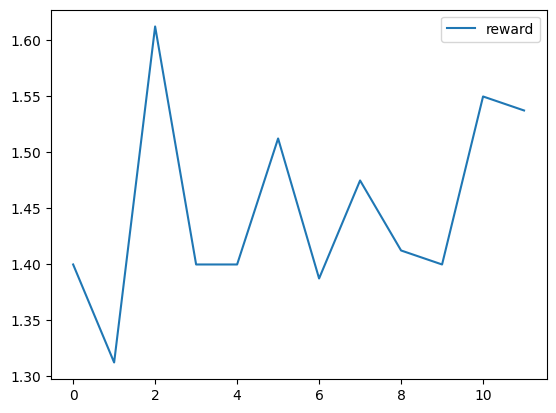

available columns:
loss
grad_norm
learning_rate
num_tokens
completions/mean_length
completions/min_length
completions/max_length
completions/clipped_ratio
completions/mean_terminated_length
completions/min_terminated_length
completions/max_terminated_length
rewards/reward_starting_at_start/mean
rewards/reward_starting_at_start/std
rewards/reward_using_comma_separated_numbers/mean
rewards/reward_using_comma_separated_numbers/std
rewards/reward_counting_by_one/mean
rewards/reward_counting_by_one/std
rewards/reward_ending_at_end/mean
rewards/reward_ending_at_end/std
reward
reward_std
frac_reward_zero_std
entropy
clip_ratio/low_mean
clip_ratio/low_min
clip_ratio/high_mean
clip_ratio/high_max
clip_ratio/region_mean
step_time
epoch
step


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()

# Show the legend
plt.legend(["reward"])
plt.show()

# If you want to graph other columns, check these out
print("available columns:")
for key in trainer.state.log_history[0].keys():
    print(key)


## Step 5. Evaluate the fine-tuned model

In [13]:
# Evaluate the fine-tuned model on the same training examples
# No changes needed in this cell

proportion_correct = 0.0

for example in ds:
    prompt = example["prompt"]
    start = example["start"]
    end = example["end"]
    result = check_counting(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        start=start,
        end=end,
    )
    proportion_correct += result

print(f"{proportion_correct}/{len(ds)} sequences correct")

Proposed: 1, 2, 3, 4, 5, 6. | Actual: 1, 2, 3, 4, 5, 6. | Matches: ✅
Proposed: 1, 2, 3, 4, 5, 6, 7. | Actual: 1, 2, 3, 4, 5, 6, 7. | Matches: ✅
Proposed: 1, 2, 3, 4, 5, 6, 7, 8. | Actual: 1, 2, 3, 4, 5, 6, 7, 8. | Matches: ✅
Proposed: 2, 3, 4, 5, 6, 7. | Actual: 2, 3, 4, 5, 6, 7. | Matches: ✅
Proposed: 2, 4, 6, 8, 10, 12, 14, 16, 18 | Actual: 2, 3, 4, 5, 6, 7, 8. | Matches: ❌
Proposed: 2, 3, 4, 5, 6, 7, 8, 9. | Actual: 2, 3, 4, 5, 6, 7, 8, 9. | Matches: ✅
Proposed: 3, 4, 5, 6, 7, 8. | Actual: 3, 4, 5, 6, 7, 8. | Matches: ✅
Proposed: 3, 4, 5, 6, 7, 8, 9. | Actual: 3, 4, 5, 6, 7, 8, 9. | Matches: ✅
Proposed: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10. | Actual: 3, 4, 5, 6, 7, 8, 9, 10. | Matches: ❌
Proposed: 4, 5, 6, 7, 8, 9. | Actual: 4, 5, 6, 7, 8, 9. | Matches: ✅
Proposed: 4, 5, 6, 7, 8, 9, 10. | Actual: 4, 5, 6, 7, 8, 9, 10. | Matches: ✅
Proposed: 4, 5, 6, 7, 8, 9, 10, 11. | Actual: 4, 5, 6, 7, 8, 9, 10, 11. | Matches: ✅
11.033333333333333/12 sequences correct


The model now performs a little better on the training data it has seen.

<br /><br /><br /><br /><br /><br /><br /><br /><br />